# Model Health and Drift Monitoring

**Purpose:** Monitor the health of the adaptive learning system, check for parameter drift, and ensure state persistence.
**Author:** Roo Code
**Date:** 2026-02-16

## Setup
This notebook uses the `ml_heating` package directly.

In [6]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Ensure project root is in path for src imports
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
if project_root not in sys.path:
    sys.path.append(project_root)

import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta, timezone

# Standard Library Imports
from src import config
from src.analysis import DataLoader, plotting
from src.unified_thermal_state import ThermalStateManager

# Configure Plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. State Inspection
Load the current persisted state of the thermal model.

In [7]:
# Initialize State Manager
state_manager = ThermalStateManager()
state_manager.load_state()
current_state = state_manager.state

print("Current Thermal State:")
print(json.dumps(current_state, indent=2))

Current Thermal State:
{
  "metadata": {
    "version": "1.0",
    "format": "unified_thermal_state",
    "created": "2026-02-12T14:38:00.966213",
    "last_updated": "2026-02-16T13:03:04.133189"
  },
  "baseline_parameters": {
    "thermal_time_constant": 21.59683493331745,
    "equilibrium_ratio": 0.17,
    "total_conductance": 0.8,
    "heat_loss_coefficient": 0.539463110154955,
    "outlet_effectiveness": 0.4826476925561557,
    "pv_heat_weight": 0.0005,
    "fireplace_heat_weight": 5.0,
    "tv_heat_weight": 0.19130751261040038,
    "source": "calibrated",
    "calibration_date": "2026-02-16T10:01:24.081891",
    "calibration_cycles": 12510
  },
  "learning_state": {
    "cycle_count": 258,
    "learning_confidence": 5.0,
    "learning_enabled": true,
    "parameter_adjustments": {
      "equilibrium_ratio_delta": 0.0,
      "total_conductance_delta": 0.0,
      "heat_loss_coefficient_delta": -0.0023186248369438944,
      "outlet_effectiveness_delta": 0.0
    },
    "parameter_bou

## 2. Parameter Drift Analysis
Analyze how model parameters have evolved over time. (Requires historical parameter logging, which we simulate here by checking current values against defaults).

In [8]:
# Compare current parameters with defaults
default_params = {
    'heat_loss_coefficient': 0.5,
    'thermal_mass': 1000.0,
    'efficiency': 0.9
}

# current_state is a dict, not an object
# We need to extract parameters from the computed parameters
computed_params = state_manager.get_computed_parameters()

drift_data = []
for key, default_val in default_params.items():
    current_val = computed_params.get(key, default_val)
    drift = current_val - default_val
    drift_pct = (drift / default_val) * 100 if default_val != 0 else 0
    
    drift_data.append({
        'parameter': key,
        'default': default_val,
        'current': current_val,
        'drift_abs': drift,
        'drift_pct': drift_pct
    })
    
drift_df = pd.DataFrame(drift_data)
print("Parameter Drift Analysis:")
print(drift_df)

Parameter Drift Analysis:
               parameter  default      current  drift_abs  drift_pct
0  heat_loss_coefficient      0.5     0.537144   0.037144   7.428897
1           thermal_mass   1000.0  1000.000000   0.000000   0.000000
2             efficiency      0.9     0.900000   0.000000   0.000000


## 3. Learning Confidence
Check the confidence levels of the learned parameters.

Global Learning Confidence: 5.00


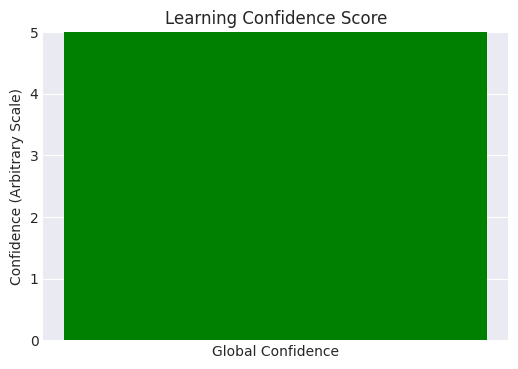

In [9]:
# Visualize Confidence
# In the unified state, confidence is a single global value, not per-parameter
learning_confidence = current_state.get('learning_state', {}).get('learning_confidence', 3.0)

print(f"Global Learning Confidence: {learning_confidence:.2f}")

# We can visualize this as a gauge or single bar
plt.figure(figsize=(6, 4))
plt.bar(['Global Confidence'], [learning_confidence], color='green' if learning_confidence > 2.0 else 'orange')
plt.title('Learning Confidence Score')
plt.ylabel('Confidence (Arbitrary Scale)')
plt.ylim(0, 5.0) # Assuming 5.0 is max reasonable confidence
plt.show()

## 4. Health Alerts
Check for any critical issues or anomalies.

In [10]:
alerts = []

# Check for low confidence
if learning_confidence < 1.0:
    alerts.append(f"Low global learning confidence: {learning_confidence:.2f}")

# Check for extreme drift
for _, row in drift_df.iterrows():
    if abs(row['drift_pct']) > 50:
        alerts.append(f"High drift for {row['parameter']}: {row['drift_pct']:.1f}%")

if alerts:
    print("⚠️ Health Alerts:")
    for alert in alerts:
        print(f"- {alert}")
else:
    print("✅ System Health: OK")

✅ System Health: OK


## 5. Conclusions
Summarize health status here.